# fm0 iq decode
Actually trying to decode the FM0 from a recording.

Close range, high power, just the access code so far.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as it

from collections import Counter
from enum import Enum

In [2]:
FILE = "/Users/ebaum/Documents/capstone/iq/ask-mag-long-30k.iq"

SPS = 32
SAMP_RATE = 30e3

class Pulse(Enum):
    SHORT_PULSE  = SPS
    LONG_PULSE   = 2 * SPS
    MID_POINT    = (SHORT_PULSE + LONG_PULSE) // 2
    NOISE_FACTOR = 0.5
    NOISE_PULSE  = SHORT_PULSE * NOISE_FACTOR

data = np.fromfile(FILE, dtype=np.float32)
bin_data = np.sign(data) / 2  # maybe later - soft decisions
print(f"loaded {len(data)} samples -> {len(data) / SAMP_RATE:.2f} sec")

loaded 2093720 samples -> 69.79 sec


In [3]:
pulse_len = np.diff(np.where(np.diff(bin_data) != 0)[0])

def find_pulses(raw_pulse):
    # this will return offset by one
    last = 0
    bit_iter = iter(raw_pulse)
    for p in bit_iter:
        if p < Pulse.NOISE_PULSE.value:
            # print("noise")
            last += p + next(bit_iter)
            continue
        else:
            if last < Pulse.MID_POINT.value:
                yield Pulse.SHORT_PULSE.value
            else:
                yield Pulse.LONG_PULSE.value
        last = p
        
def convert_symbols(clean_pulse):
    n = 0
    pulse_iter = iter(clean_pulse)
    for p in pulse_iter:
        if p == Pulse.SHORT_PULSE.value:
            try:
                p = next(pulse_iter)
            except StopIteration:
                break
            if p == Pulse.SHORT_PULSE.value:
                # short short
                yield 0
            else:
                # short long shoulnd't happen, lost sync.
                # print("sync", n)
                # yield 0?
                yield 1
        elif p == Pulse.LONG_PULSE.value:
            yield 1
        n += 1

clean_pulse = list(find_pulses(pulse_len))
symbols = list(convert_symbols(clean_pulse))

<IPython.core.display.Javascript object>


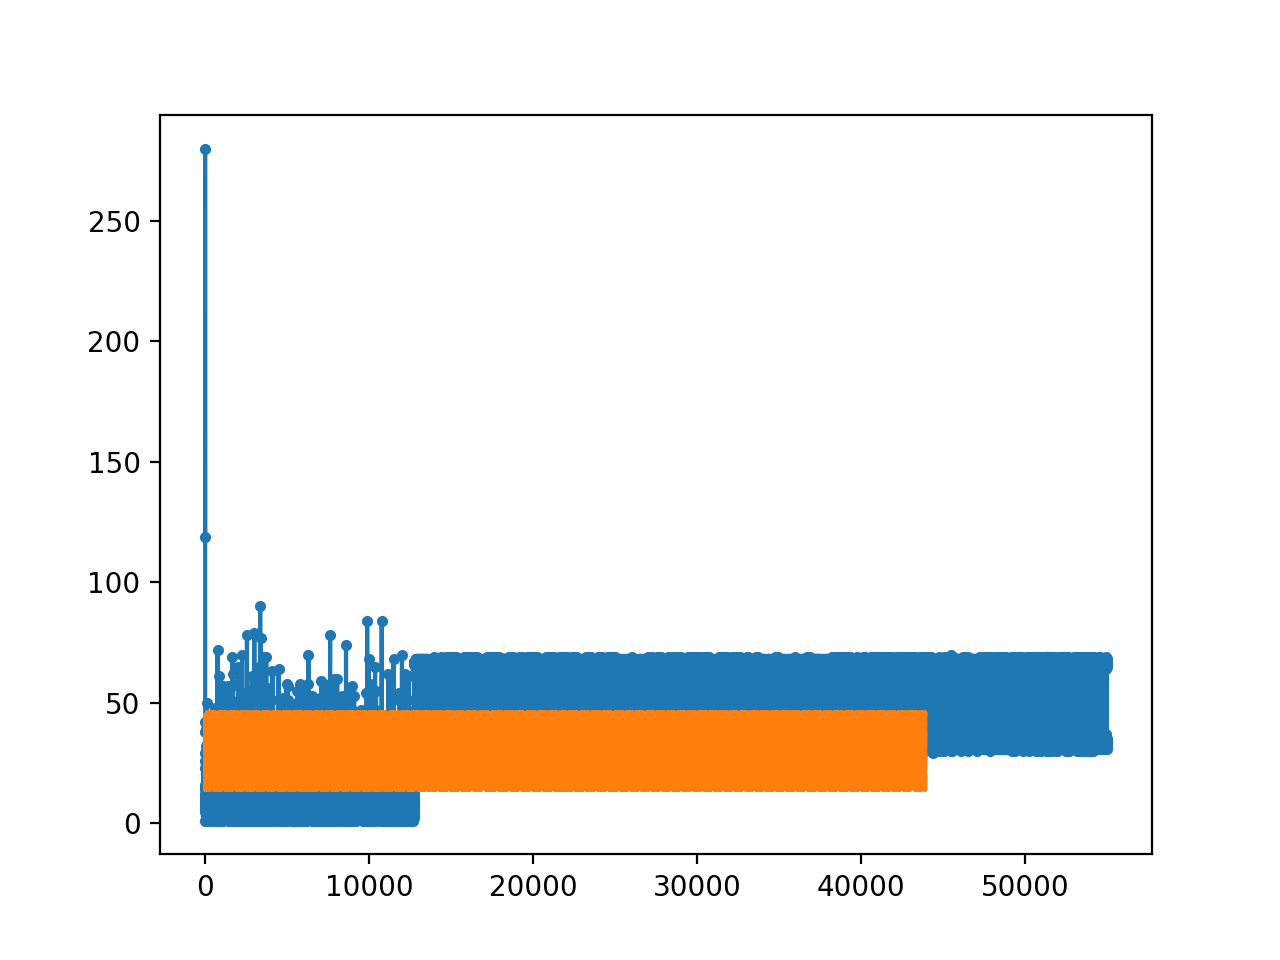

In [4]:
%matplotlib notebook
plt.plot(pulse_len, '.-')
plt.plot(np.array(clean_pulse)[10:] - 18, '--')
# plt.xlim(20000, 20100)
# plt.hlines(Pulse.NOISE_PULSE.value, 0, 11000)

<IPython.core.display.Javascript object>


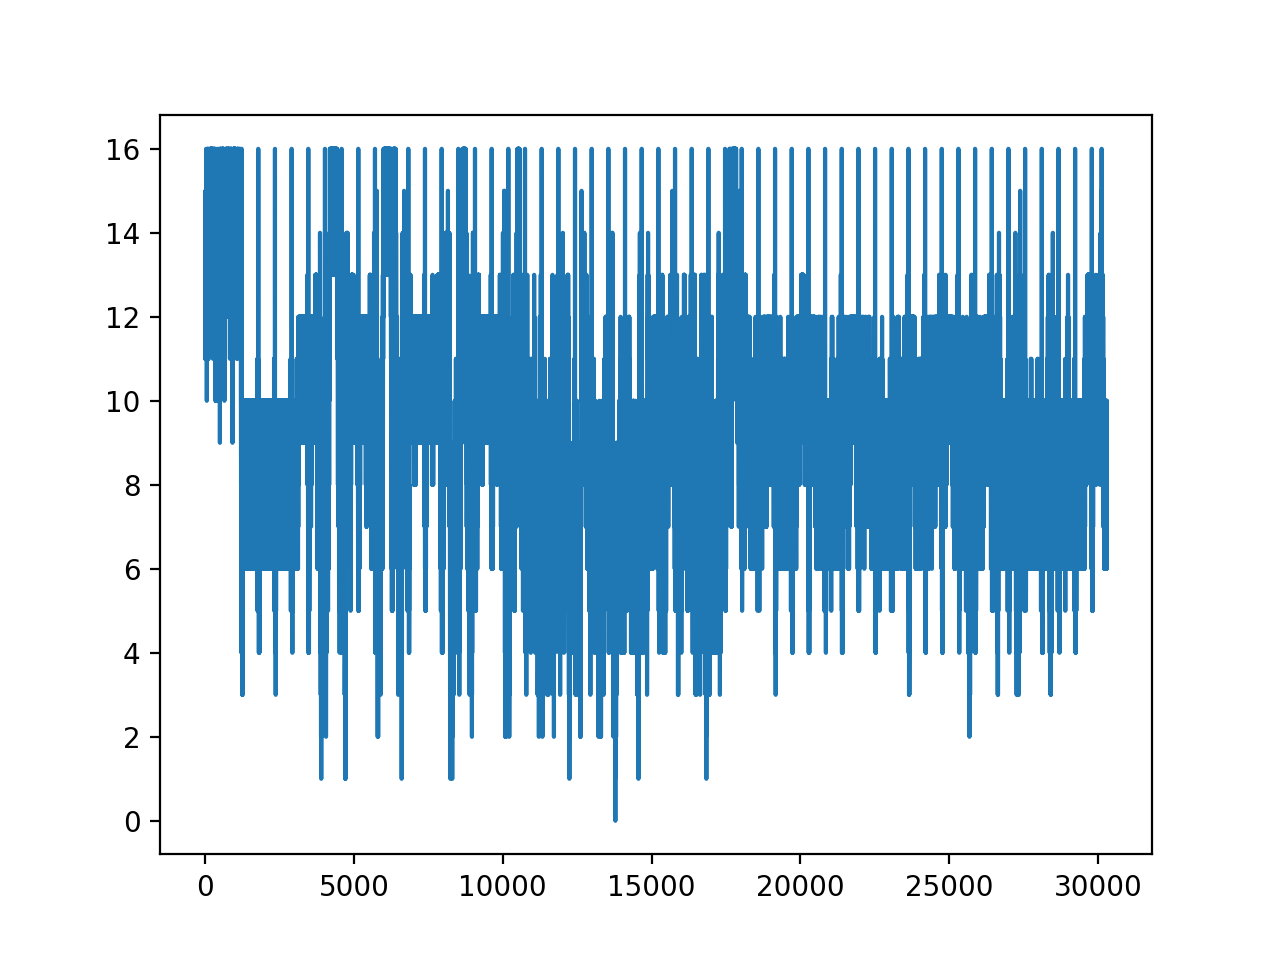

In [5]:
# arbitrary for now
CORR_LIMIT = 15

# ACCESS_CODE = 0xe15ae893
ACCESS_CODE = 0xe15ae893
ac_arr = np.array(list(map(int, bin(ACCESS_CODE)[2:])))

corr = np.correlate(np.array(symbols), ac_arr)
ac_loc = np.where(corr == np.max(corr))[0]

for L in ac_loc:
    ac = hex(int(''.join(map(str, symbols[L:L+len(ac_arr)])), 2))
#     print(f"{L:5} {ac}")

plt.figure()
plt.plot(corr)

In [6]:
def binlist2num(b):
    return int(''.join(map(str, b)), 2)

def parsebytelist(b):
    while b:
        byte = list(it.islice(b, 8))
        
        if not byte:
            break
            
        yield binlist2num(byte)

bit_iter = iter(symbols)

corr = np.correlate(np.array(symbols), ac_arr)
packet_starts = np.where(corr >= 16)[0]

sensor_data = []

last_sqn = None

i = 0

while i < len(symbols):
    corr = np.correlate(symbols[i:i+len(ac_arr)], ac_arr)[0]
#     print(i, corr)
    if corr < 16:
        i += 1
        continue
    
    bit_iter = iter(symbols[i:])
    access_code = binlist2num(it.islice(bit_iter, 32))
    sqn = binlist2num(it.islice(bit_iter, 8))
    pkt_len = binlist2num(it.islice(bit_iter, 8))
    
    data = list(parsebytelist(it.islice(bit_iter, pkt_len * 8)))

    if last_sqn is not None and (last_sqn + 1) & 0xFF != sqn:
        sqn_str = 'ERR'
        sensor_data.extend([-10]) # just for viz purposes
        data = None
        i += 1 # no dice here - so we want to check the next bit
    else:
        sqn_str = 'OK'
        sensor_data.extend(data)
        i += 32 + 8 * 2 + pkt_len * 8 # this worked out - so skip to the next packet!
    
    print(f"{i} {access_code:x} {sqn=:x} {sqn_str:3} {pkt_len=} {data}")
    
    
    last_sqn = sqn

# plt.figure()
# plt.plot(np.correlate(np.array(symbols), ac_arr))

1084 ff7eeefb sqn=f7 OK  pkt_len=125 [251, 191, 253, 254, 251, 63, 239, 254, 159, 253, 255, 227, 255, 255, 255, 255, 255, 239, 239, 255, 183, 255, 247, 253, 187, 255, 191, 255, 253, 143, 255, 223, 255, 251, 254, 173, 189, 239, 206, 223, 187, 247, 239, 251, 159, 255, 237, 127, 63, 253, 255, 250, 122, 215, 255, 247, 255, 239, 215, 255, 127, 255, 118, 191, 255, 251, 255, 247, 255, 255, 250, 247, 155, 191, 253, 231, 247, 255, 63, 247, 127, 255, 215, 255, 253, 251, 253, 247, 253, 247, 255, 255, 254, 254, 249, 239, 254, 251, 191, 239, 223, 255, 127, 187, 247, 255, 212, 127, 207, 255, 255, 255, 239, 253, 255, 223, 255, 239, 255, 251, 255, 189, 253, 255, 94]
1087 fbdeffbf sqn=ff ERR pkt_len=253 None
1089 ef7bfeff sqn=ff ERR pkt_len=247 None
1099 effbffff sqn=df ERR pkt_len=252 None
1104 ff7ffffb sqn=ff ERR pkt_len=158 None
1107 fbffffdf sqn=fc ERR pkt_len=247 None
1108 f7ffffbf sqn=f9 ERR pkt_len=239 None
1123 ffdffcf7 sqn=ff ERR pkt_len=255 None
1153 ffffefbf sqn=9b ERR pkt_len=223 None
1182 

<IPython.core.display.Javascript object>


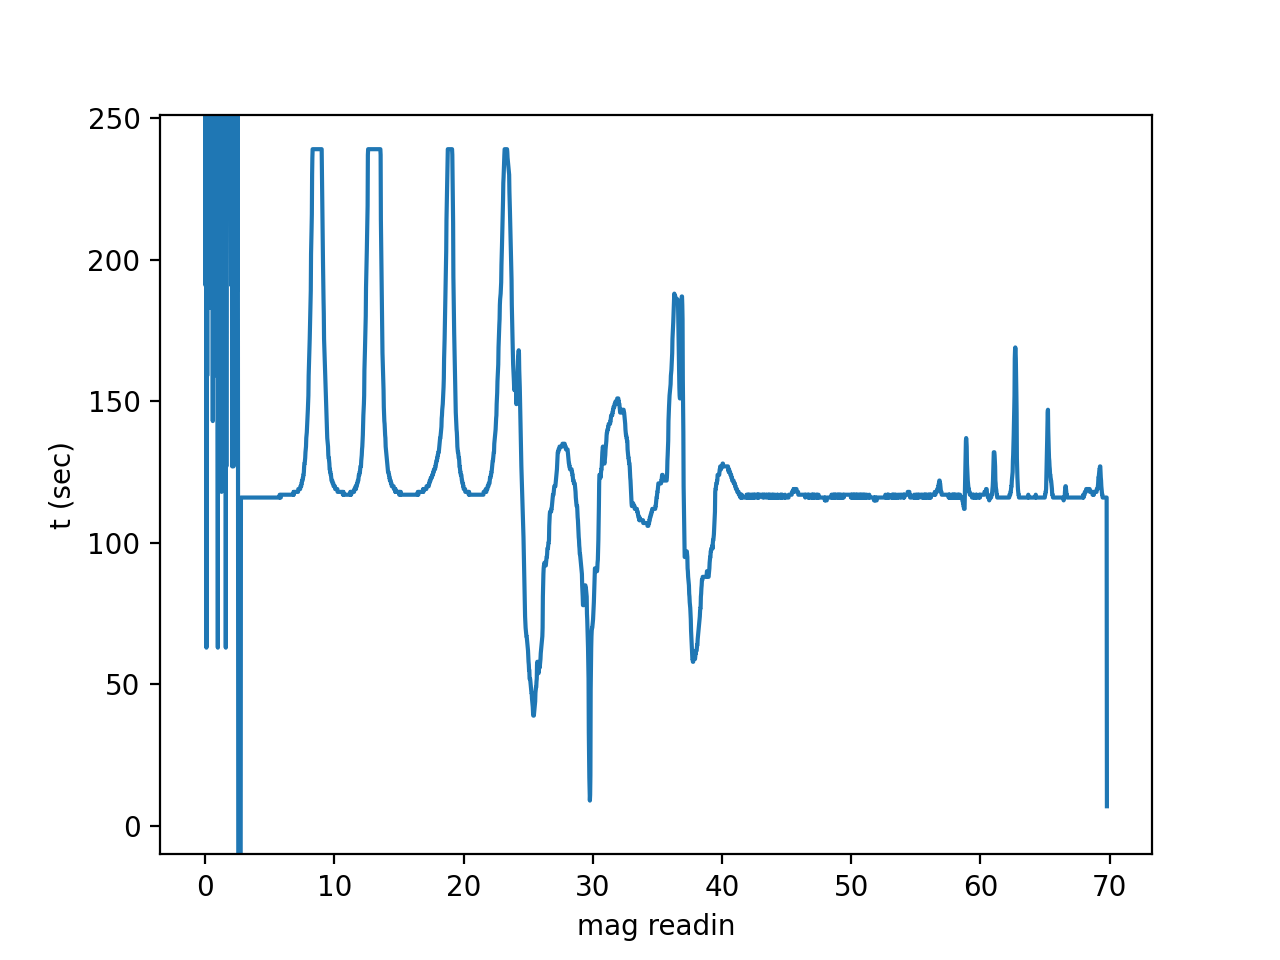

Text(0.5, 0, 'mag readin')

In [7]:
plt.figure()
# this is slightly inexact because of packet headers but whatever
t = np.linspace(0, len(bin_data) / 30e3, len(sensor_data))
plt.plot(t, sensor_data)
plt.ylim(-10, 251)
plt.ylabel('t (sec)')
plt.xlabel('mag readin')

In [335]:
len(symbols)/len(sensor_data)

8.876550868486353